In [1]:
import numpy as np
import skimage
import scipy.io
import pydicom
import os
import sys
import nibabel as nb
import pandas as pd
import datetime
from pylab import *
import ants

In [2]:
import plotly.graph_objects as go

In [3]:
#filesystem for the package
cur_path = os.getcwd()
print("Current Working Directory: "+ cur_path)
try:
    os.makedirs(cur_path+'/params')
    os.makedirs(cur_path+'/visuals/3d_vtk')
    os.makedirs(cur_path+'/visuals/stills_2d')
    os.makedirs(cur_path+'/output')
    os.makedirs(cur_path+'/datasets')
    os.makedirs(cur_path+'/datasets/raw')
    print("Directory Structure created successfully.")
except:
    print("The file structure creation failed.")

Current Working Directory: /Users/shwetankpanwar/Documents/BTPData/python_scripts
The file structure creation failed.


In [4]:
#input variables...to be saved inside the input_params.csv
if os.path.isfile(cur_path+'/params/input_params.csv'):
    file = pd.read_csv(cur_path+'/params/input_params.csv')
    raw_data_dir = file['raw'].values[0]
    nifti_dir = file['nifti'].values[0]
else:
    path_raw = str(cur_path)+"/datasets/raw/"
    path_nifti = str(cur_path)+"/datasets/nifti/"
    d_modified = datetime.date.today()
    file_dataframe = {'raw': [path_raw], 'date_added': [d_modified], 'nifti': [path_nifti]}
    r = pd.DataFrame(file_dataframe)
    r.to_csv(cur_path+'/params/input_params.csv')

In [5]:
#raw data processing goes here....The functions are described properly in the preprocessing.ipynb file

In [6]:
def dcm_lst(subject_folder):
    #Function to develop list of DICOM files present in a directory.
    #Filename should start with a single alphabet followed by a digit i.e. 'Z01', 'Z11' 
    lstDCM = []
    if not os.path.exists(subject_folder):
        print("Subject Path not found. Exiting..")
        sys.exit()
    for dirname, subdirList, fileList in os.walk(subject_folder):
        for filename in fileList:
            if filename[1].isdigit():
                lstDCM.append(os.path.join(dirname,filename))
    return lstDCM  

In [7]:
def dcm_array(subject_folder, orientation = None):
    lst_DCM = dcm_lst(subject_folder)
    #print(lst_DCM)
    refSlice = pydicom.read_file(lst_DCM[0])
    pixel_dim = (int(refSlice.Rows),int(refSlice.Columns),int(len(lst_DCM)))
    print("Array Dimensions:")
    print(pixel_dim)
    array_dicom = np.zeros(pixel_dim,dtype = refSlice.pixel_array.dtype)
    for filename in lst_DCM:
        da = pydicom.read_file(filename)
        array_dicom[:,:,(int(da.InstanceNumber)-1)] = da.pixel_array
    return array_dicom    

In [8]:
#to get the list of individual patient folder inside the raw data folder
def get_immediate_subdirectories(a_dir):
    return [name for name in os.listdir(a_dir)
            if os.path.isdir(os.path.join(a_dir, name))]

In [44]:
#image display and storage
def imgplot(volume1, volume2 = None,  size = 'big',scaling_factor = 1):
    import matplotlib.pyplot as plt
    slice_no1 = int(volume1.shape[2]/2)
    if volume2.all() == None:
        if size == 'big':
            plt.figure(figsize = (8,6))
            plt.imshow(volume1[:,:,slice_no1], cmap = plt.get_cmap('gray'))
            plt.show()
        elif size == 'small':
            plt.imshow(volume1[:,:,slice_no1], cmap = plt.get_cmap('gray'))
            plt.show()
    elif volume2.all() != None:
        slice_no2 = int(volume2.shape[2]/2)
        plt.figure(figsize = (10,12))
        plt.subplot(2,2,1)
        plt.imshow(volume1[:,:,slice_no1], cmap = plt.get_cmap('gray'))
        plt.subplot(2,2,2)
        plt.imshow(volume2[:,:,slice_no2], cmap = plt.get_cmap('gray'))
        plt.show()

In [40]:
patients_dir = get_immediate_subdirectories(raw_data_dir)
patient = patients_dir[1]

In [12]:
#raw_pixel_array_formation
p2_array_raw = dcm_array(raw_data_dir+'/'+patient)

Array Dimensions:
(512, 512, 68)


In [13]:
#Cell to convert the raw dicom to nifti format and transform it into MNI space
nii_file = patient + '_unskulled_anat.nii'

In [14]:
#FSL Brain Extraction Tool(BET) for skull stripping
#parameters:
#path_nifti = Path where nifti files will be stored
#patient = name of the patient file
def skull_stripping(path_nifti,patient):
    from nipype.interfaces import fsl 
    import gzip
    import shutil    
    nii_file = patient + '_unskulled_anat.nii'
    btr = fsl.BET()
    btr.inputs.in_file = path_nifti + patient + '.nii'
    btr.inputs.frac = 0.7
    btr.inputs.out_file = path_nifti + nii_file
    btr.cmdline
    res = btr.run()
    print('Skull stripping done successfully.')
    with gzip.open(path_nifti + nii_file + '.gz', 'rb') as f_in:
        with open(path_nifti + nii_file, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
    try:
        os.remove(path_nifti + nii_file + '.gz')
        print("Skull stripped file saved successfully!")
    except:
        print('Some error occured while saving the file.')

In [13]:
skull_stripping(nifti_dir, patient)

Skull stripping done successfully.
Skull stripped file saved successfully!


In [15]:
#p2 = nb.load(nifti_dir + patient + '_unskulled_anat.nii').get_fdata()
p2 = ants.image_read(nifti_dir + patient + '_unskulled_anat.nii')

In [16]:
#image preprocessing begins here...
#Steps can be found in the paper :
#Saifeng et. al. "Cerebral microbleed detection using Susceptibility Weighted Imaging and deep learning" Neuroimage

#step1 : Bias Field Correction using N4 algorithm
p2_corrected = ants.n4_bias_field_correction(p2)

In [30]:
#Non rigid registration of the patient brain to mni space
#mni template citiation:
#VS Fonov, AC Evans, K Botteron, CR Almli, RC McKinstry, DL Collins and BDCG, 
#Unbiased average age-appropriate atlases for pediatric studies, NeuroImage,Volume 54, Issue 1, January 2011, 
#ISSN 1053–8119, DOI: 10.1016/j.neuroimage.2010.07.033
#
#VS Fonov, AC Evans, RC McKinstry, CR Almli and DL Collins, Unbiased nonlinear average age-appropriate brain 
#templates from birth to adulthood, NeuroImage, Volume 47, Supplement 1, July 2009, 
#Page S102 Organization for Human Brain Mapping 2009 Annual Meeting, 
#DOI: http://dx.doi.org/10.1016/S1053-8119(09)70884-5
#
def mni_template_registration(cur_path, patient_image, patient_name):
    import nibabel as nb
    import ants
    if not os.path.isfile(cur_path + '/datasets/nifti/'+ patient_name + '_mni_registered.nii'):        
        fixed = ants.image_read(cur_path + '/datasets/mni_t2_template.nii')
        moving = patient_image
        fixed.plot(overlay = moving, title = 'Before Registration')
        mytx = ants.registration(fixed=fixed , moving=moving, type_of_transform='SyN')
        warped_moving = mytx['warpedmovout']
        fixed.plot(overlay=warped_moving,
                   title='After Registration')
        nib_image = warped_moving.to_nibabel()
        nb.save(nib_image, cur_path + '/datasets/nifti/'+ patient_name + '_mni_registered.nii')
        return warped_moving
    else:
        warped = ants.image_read(cur_path + '/datasets/nifti/'+ patient_name + '_mni_registered.nii')
        return warped        

In [31]:
p2_mni = mni_template_registration(cur_path, p2, patient)

In [33]:
p2_mni

ANTsImage (LPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (197, 233, 189)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (98.0, 134.0, -72.0)
	 Direction  : [-1.  0.  0.  0. -1.  0.  0.  0.  1.]

In [21]:
#implementing fast radial symmetry transform inspired from the ideas suggested by Loy and Zelinsky.
#Loy, G., & Zelinsky, A. (2002). A fast radial symmetry transform for detecting points of interest. 
#Computer Vision, ECCV 2002.
from frst import frst
import SimpleITK as sitk
import skimage 

In [36]:
p2_arr = p2_mni.numpy()  #conversion of ant image into the numpy image

In [27]:
points_of_int = frst.frst(p2_arr[:,:,79], 3,3,0.2,2.5,mode = 'BOTH')

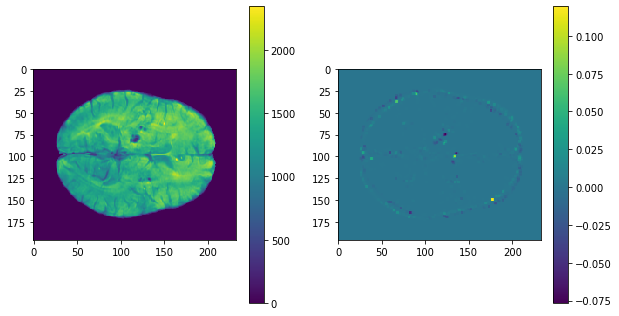

In [28]:
figure(figsize = (10,12))
subplot(2,2,1)
imshow(p2_arr[:,:,79])
colorbar()
subplot(2,2,2)
imshow(points_of_int[:197,:233])
colorbar()
show()

In [68]:
#Fast radial transformation on all the slices of the image
#INPUTS:
#patient - ANTs image on which mni registration has been applied. To be converted to numpy for further operation.
def fast_radial_symmetry_transform_3d(patient,rad,alpha,beta,std):
    patient = patient.numpy()
    from frst import frst
    l = patient[:,:,5].shape[0]
    b = patient[:,:,5].shape[1]
    transform_matrix = np.zeros_like(patient)
    for i in range(patient.shape[2]):
        temp = frst.frst(patient[:,:,i],rad,alpha,beta,std,mode = 'BOTH')
        transform_matrix[:,:,i] = temp[:l,:b]
    return transform_matrix    

In [69]:
transform_matrix = fast_radial_symmetry_transform_3d(p2_mni,3,0.3,0.2,1) 

/usr/local/lib/python3.7/site-packages/frst/frst.py:77: RuntimeWarning: invalid value encountered in true_divide
  O_n = O_n / float(np.amax(O_n))
/usr/local/lib/python3.7/site-packages/frst/frst.py:81: RuntimeWarning: invalid value encountered in true_divide
  M_n = M_n / M_max


In [70]:
#Connectivity analysis which is needed to be done in order to cluster different points obtained by frst.

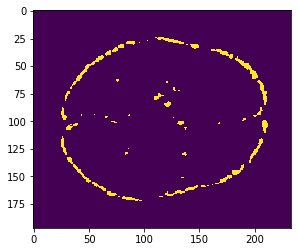

In [100]:
figure()
imshow(transform_matrix[:,:,79]>0.050)
show()

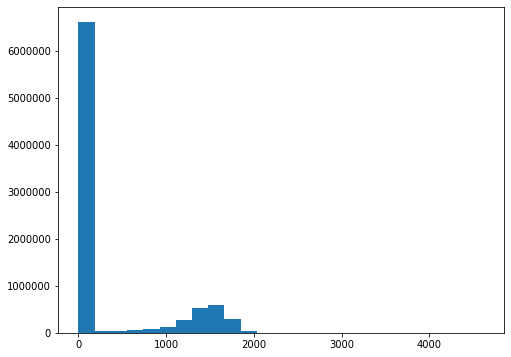

In [98]:
#histogram plotting for the image
import matplotlib.pyplot as plt
plt.figure(figsize = (8,6))
hist = plt.hist(p2_arr.ravel(),bins = 'auto')

In [35]:
p2_masked = ((p2_arr < 1600))*p2_arr

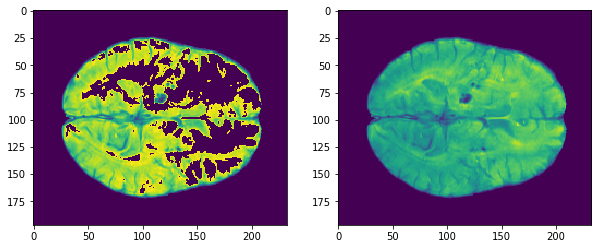

In [36]:
figure(figsize = (10,12))
subplot(2,2,1)
imshow(p2_masked[:,:,79])
subplot(2,2,2)
imshow(p2_arr[:,:,79])
show()

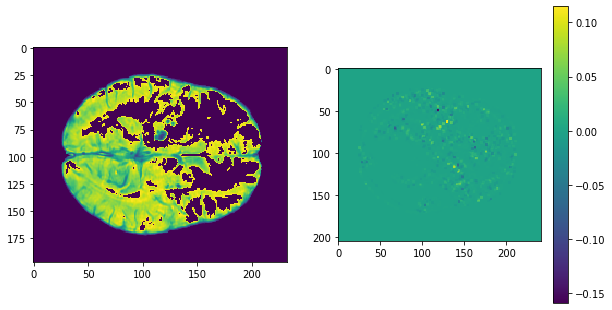

In [39]:
figure(figsize = (10,12))
subplot(2,2,1)
imshow(p2_masked[:,:,79])
subplot(2,2,2)
imshow(t)
colorbar()
show()

In [37]:
t = frst.frst(p2_masked[:,:,79],4,3,0.4,1)

In [42]:
y = t>0.04
lm = 

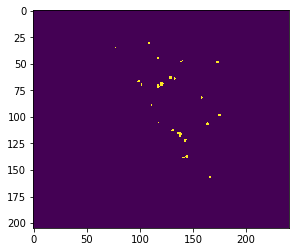

In [43]:
figure()
imshow(y)
show()

In [56]:
fig = go.Figure(data = go.Heatmap(z = (p2_arr[:,:,79])))
fig.update_layout(width = 600, height = 550, autosize = False)
fig.show()

In [78]:
r = frst.frst(p2_arr[:,:,79],3,3,0.02,1)
fig = go.Figure(data = go.Heatmap(z = ((r[:197,:233]>0.0)*r[:197,:233])))
fig.update_layout(width = 600, height = 550, autosize = False)

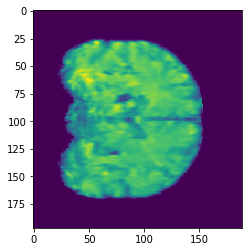

In [40]:
figure()
imshow(p2_arr[:,120,:])
show()

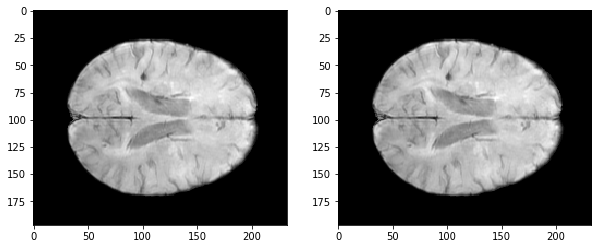

In [46]:
imgplot(p2_arr,p2_arr)

'p1'